In [1]:
import sys,os
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from scipy.stats import norm
from scipy.optimize import curve_fit

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import MB_equations as MBe
import TimestreamHelperFunctions as Thf

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Define the MB parameters
alpha = MB_fit_vals[2]
Delta = MB_fit_vals[1] ## meV
D     = Delta*1e-3     ##  eV

## Temperature of the device
T = 10.0e-3 ## K

## Superconducting volume per resonator
V = 3e4 ## um^3

## Energy of the incident photons
hv = 2.64 ## eV

## Resonators per device
M_NEXUS    = 1

In [9]:
datapath = '/data/USRP_Laser_Data'
series   = "20230215_101743"
f_name   = series+"_OF_pulse_amps.h5"
f_path   = os.path.join(datapath,f_name)

data_df = pd.read_hdf(f_path,"data")
fits_df = pd.read_hdf(f_path,"fit")
sums_df = pd.read_hdf(f_path,"sum")
maxs_df = pd.read_hdf(f_path,"max")
b7_res  = pd.read_hdf(f_path,"b7_res")["b7_res"][0]
r_fit   = pd.read_hdf(f_path,"r_fit")["r_fit"][0]
print("Baseline resolution:", b7_res*100, "% of tallest peak")
print("Responsivity per photon:", r_fit, "df/f per photon")

Baseline resolution: 0.7784749719521108 % of tallest peak
Responsivity per photon: 6.404841792336304e-05 df/f per photon


In [4]:
sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)

md, charFs, charZs = Thf.UnpackSummary(sum_file, verbose=False)
rf_power = md['power']   ## dBm at USRP
tx_gain  = md['tx_gain'] ## dB
f        = charFs[1]   ## MHz
print("RF Power at USRP:", rf_power+tx_gain-line_atten_dB, "dBm")

RF Power at USRP: -72.5 dBm


/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


In [5]:
k2 = MBe.kappa_2(T, f*1e6, D)[0] *1e6*1e6*1e6

print("Readout Power:", rf_power+tx_gain-line_atten_dB, "dBm")
print("Readout Freq.:", f[0] , "MHz")
print("Device Temp.: ", T*1e3, "mK")
print("==============================")
print("alpha: ", alpha*100, "%")
print("Delta: ", Delta    , "meV")
print("V:     ", V        , "um^3")
print("k2:    ", k2       , "um^3")

Readout Power: -72.5 dBm
Readout Freq.: 4241.97901 MHz
Device Temp.:  10.0 mK
alpha:  3.801 %
Delta:  0.184 meV
V:      30000.0 um^3
k2:     3.9131640517538905e-07 um^3


In [6]:
s_df_NEXUS = 4.65e-7

mu_amplitdue_dff = np.array([
    s_df_NEXUS,    ## 5.0 V
    3.8044e-7,     ## 4.5 V
    2.9523e-7,     ## 4.0 V
    2.0400e-7,     ## 3.5 V
    1.0354e-7,     ## 3.0 V
    0.1127e-7,     ## 2.5 V
])

In [7]:
## Baseline resolutions
sig_qp  = 2 * b7_res * s_df_NEXUS / (alpha*k2)
sig_abs = sig_qp * V * D

print("QP resolution:",sig_qp,"um^-3")
print("Absorbed energy resolution:",sig_abs,"eV")

QP resolution: 0.4867452008821704 um^-3
Absorbed energy resolution: 2.6868335088695807 eV


In [8]:
## Energy resolution from fit
sig_dep = b7_res / (r_fit/hv)
print("Deposited energy resolution:",sig_dep,"eV")

## Eta phonon
eta_ph_val = sig_abs / sig_dep
print("Eta phonon:",eta_ph_val*100,"%")

Deposited energy resolution: 320.8781719499591 eV
Eta phonon: 0.8373375766079195 %


In [ ]:
#### =============================================================== ####
## Try to calculate eta_ph from largest pulse amplitude distribution
## This does not use the fit value
#### =============================================================== ####

## Calculate qp density corresponding to a specific pulse height
n_qp = 2 * s_df_NEXUS / (alpha *k2)
print("n_qp:", 2 * mu_amplitdue_dff / (alpha *k2))

## Calculate how many photons correpsond to that qp density (x 1/eta_ph)
N_gamma = n_qp * M_NEXUS * V * D / (hv)

## Calculate photon shot noise prefactor (x sqrt(eta_ph))
sigma_LED_df = np.sqrt( (1/M_NEXUS) * (alpha/2.) * (hv/D) * (k2/V) * s_df_NEXUS  )

## Set a limit on eta_ph (x f^2)
ratio = np.power( s_df_NEXUS / sigma_LED_df ,2)
print("eta_ph =",ratio,"f")

print("Sig at highest mu:",fits_df["5.0"][1],2)
frac = np.sqrt( np.power(fits_df["5.0"][1],2) - np.power(b7_res,2) )

eta_ph_val_prime = ratio*np.power( frac ,2)

print("For f="+str(100.0*frac)+"%, eta_ph =", eta_ph_val)
    
## Average energy per pulse
E = (2/(alpha*k2)) * mu_amplitdue_dff * (V*Delta/1e3) / eta_ph_val_prime
print(E/1e3,"keV")

## Average number of photons
print(np.round(E/hv),"photons")

In [21]:
def frac_to_E_keV(frac):
    return (2/(alpha*k2)) * (frac*s_df_NEXUS) * (V*Delta/1e3) / eta_ph_val / 1e3

def E_keV_to_photon(E_keV):
    return E_keV*1e3/hv

print(E_keV_to_photon(frac_to_E_keV(1.0)))

15613.188153945463


In [11]:
keys = np.array(data_df.keys())
voltages = keys.astype(float)

In [12]:
cmap  = plt.get_cmap('OrRd')
nbins = 20

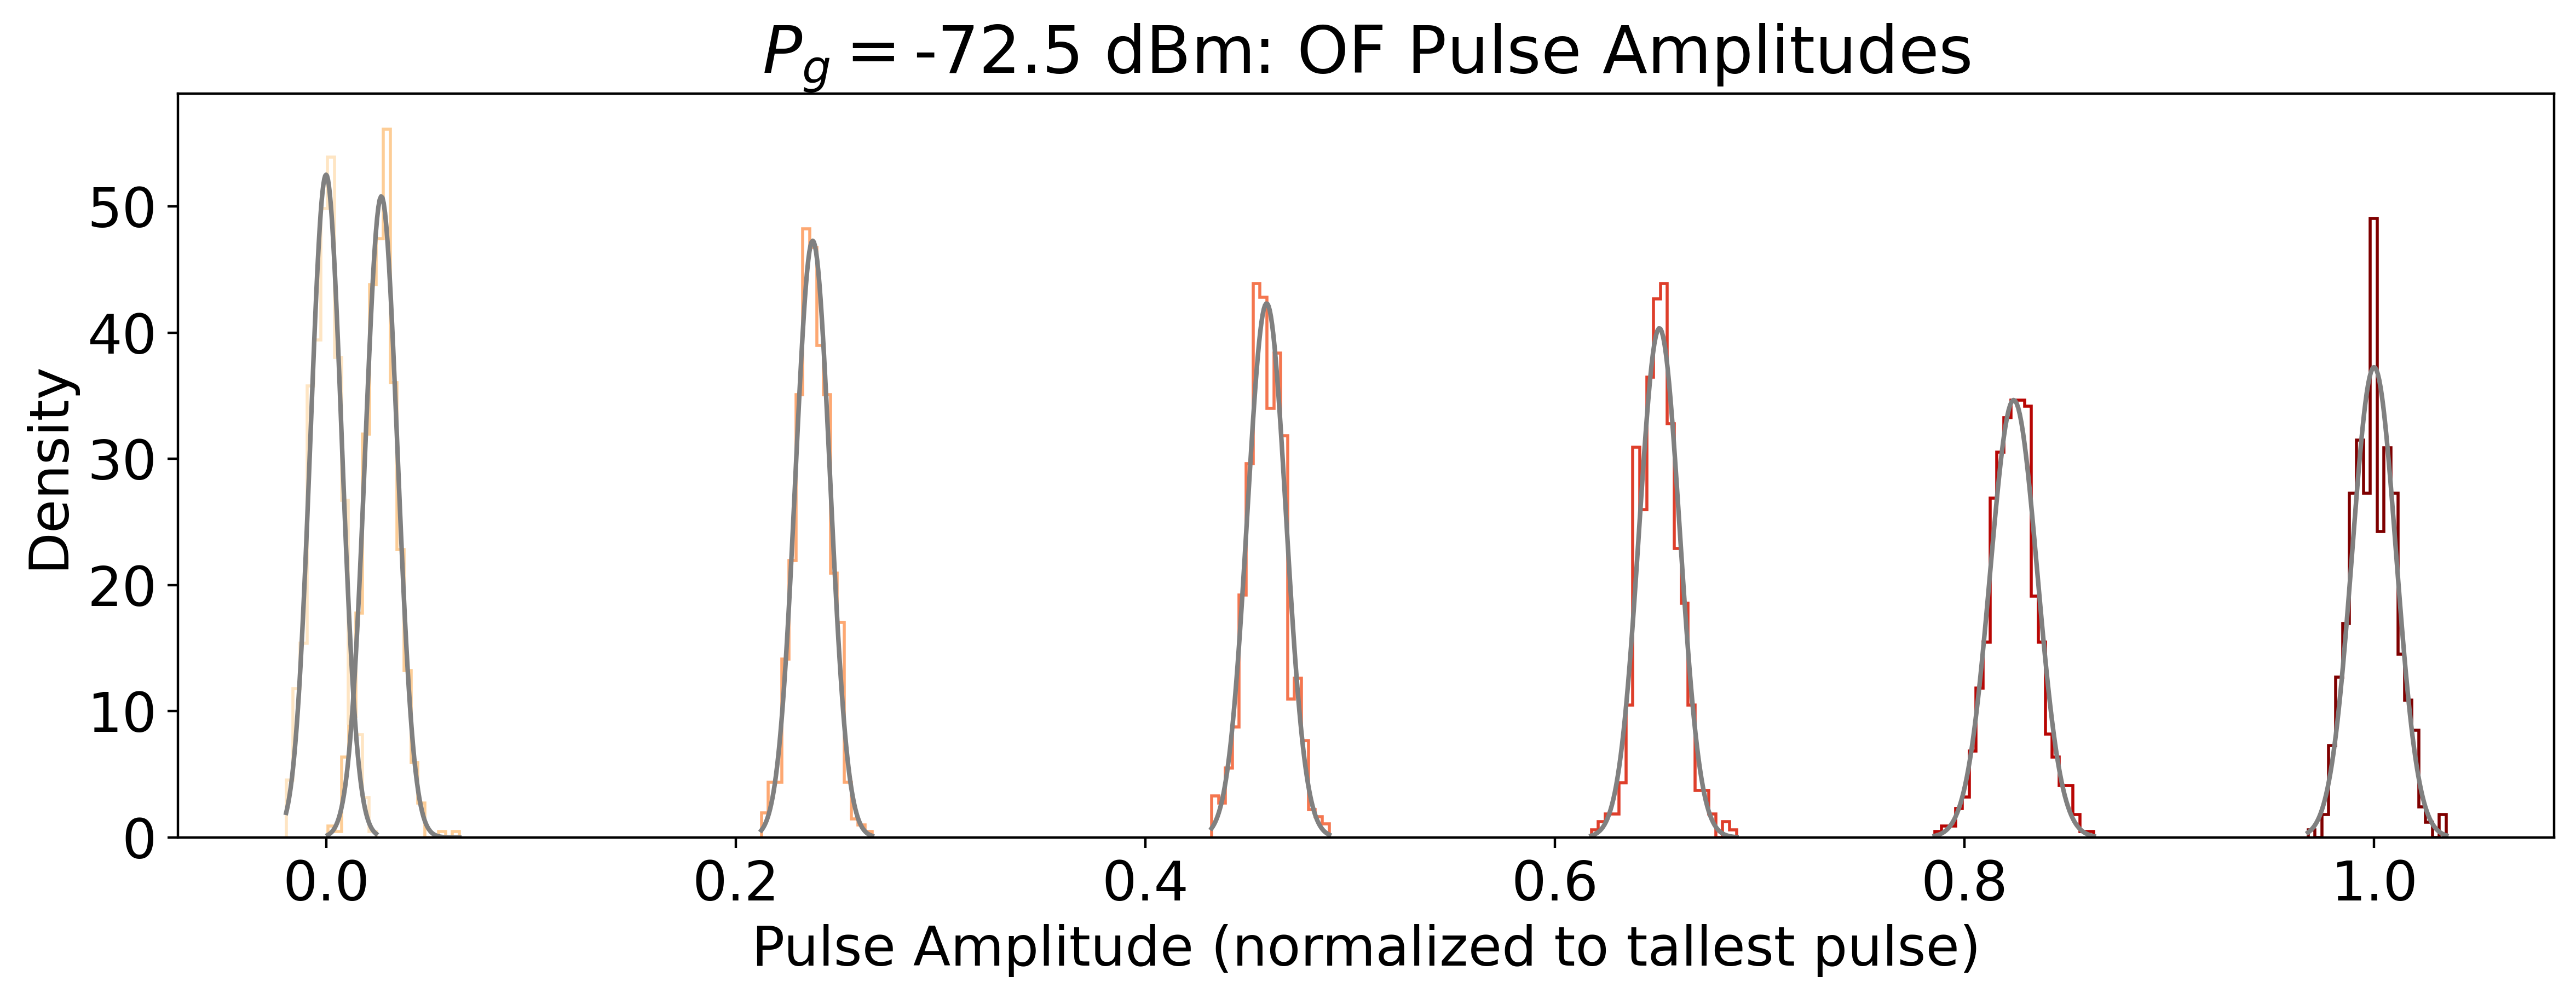

In [13]:
plt.figure(figsize=(14,4.5),dpi=400)
ax0 = plt.gca()

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    
    mu,sig = fits_df[keys[i]]
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        n, bins, patches = plt.hist(data,bins=nbins,fill=False,histtype='step',label='radians',color=color,density=1.0)
        bin_width = bins[1]-bins[0]
    else:
        n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',color=color,density=1.0)

    plt.plot(np.linspace(bins[0],bins[-1],100),
             norm.pdf(np.linspace(bins[0],bins[-1],100),mu,sig),
             c='gray')

ax0.set_xlabel('Pulse Amplitude (normalized to tallest pulse)')
ax0.set_ylabel('Density')
ax0.set_title(r'$P_g=$'+str(rf_power+tx_gain-line_atten_dB)+' dBm: OF Pulse Amplitudes')
if False:
    ylim = ax0.get_ylim()
    ax0.set_yscale('log')
    ax0.set_ylim([1e0,ylim[1]])

Text(0.5, 0, 'Number of Photons')

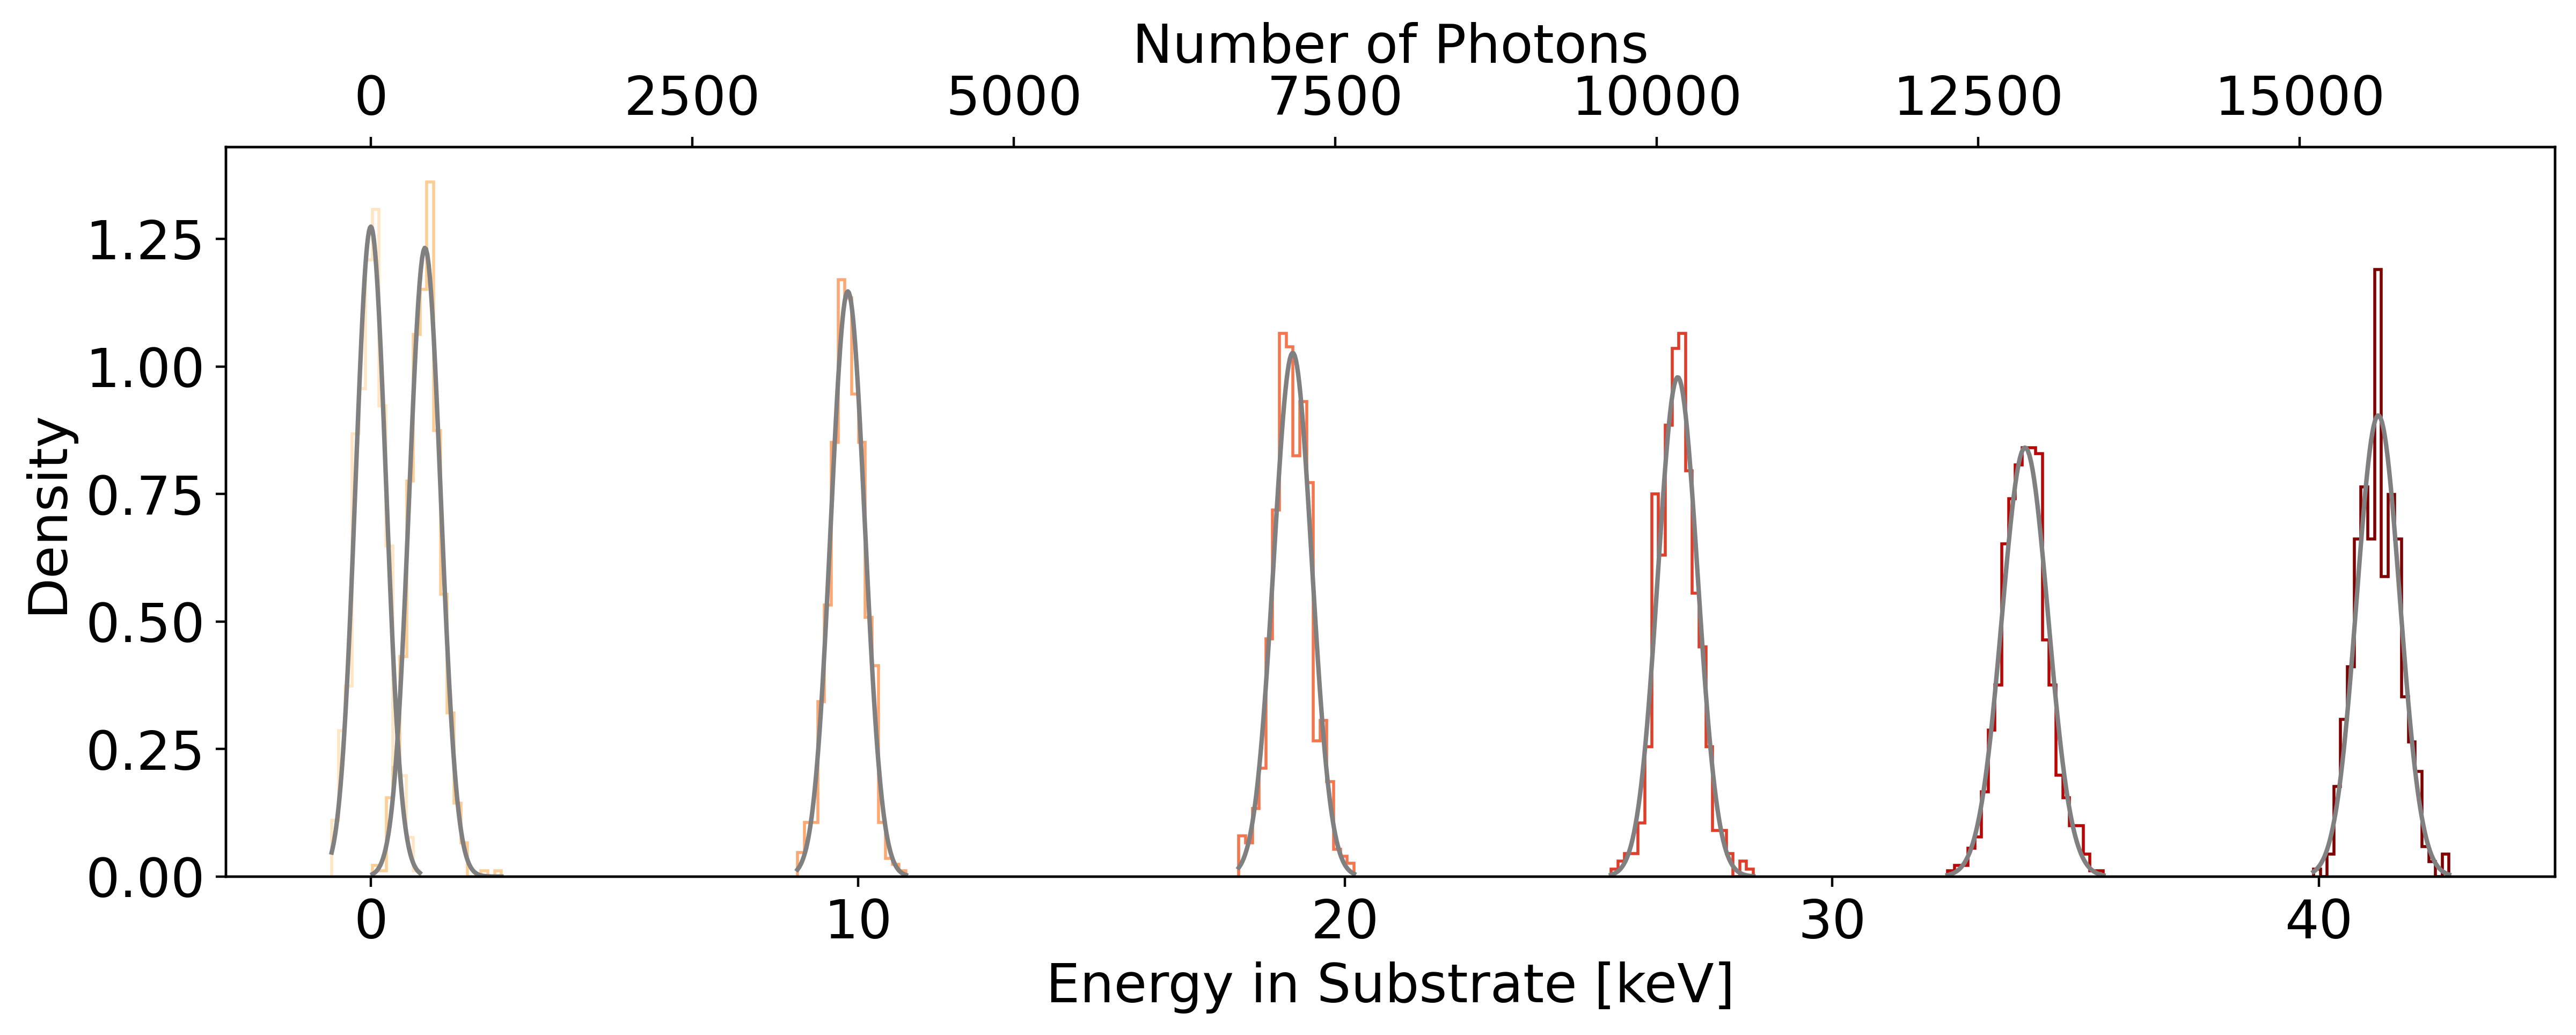

In [14]:
plt.figure(figsize=(14,4.5),dpi=400)
ax0 = plt.gca()

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    data = frac_to_E_keV(data)
    
    mu,sig = fits_df[keys[i]]
    
    mu = frac_to_E_keV(mu)
    sig = frac_to_E_keV(sig)
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        n, bins, patches = plt.hist(data,bins=nbins,fill=False,histtype='step',label='radians',color=color,density=1.0)
        bin_width = bins[1]-bins[0]
    else:
        n, bins, patches = plt.hist(data,bins=np.arange(min(data), max(data) + bin_width, bin_width),fill=False,histtype='step',color=color,density=1.0)

    plt.plot(np.linspace(bins[0],bins[-1],100),
             norm.pdf(np.linspace(bins[0],bins[-1],100),mu,sig),
             c='gray')

ax0.set_xlabel('Energy in Substrate [keV]')
ax0.set_ylabel('Density')
if False:
    ylim = ax0.get_ylim()
    ax0.set_yscale('log')
    ax0.set_ylim([1e0,ylim[1]])
    
ax1 = ax0.twiny()
ax1.set_xlim(E_keV_to_photon(np.array(ax0.get_xlim())))
ax1.set_xlabel("Number of Photons")

energy resolution estimate is: 320.8781719499591


<ipython-input-17-a98c1b862aa6>:34: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(b7_res**2 + (mu)*r)
/usr/local/share/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


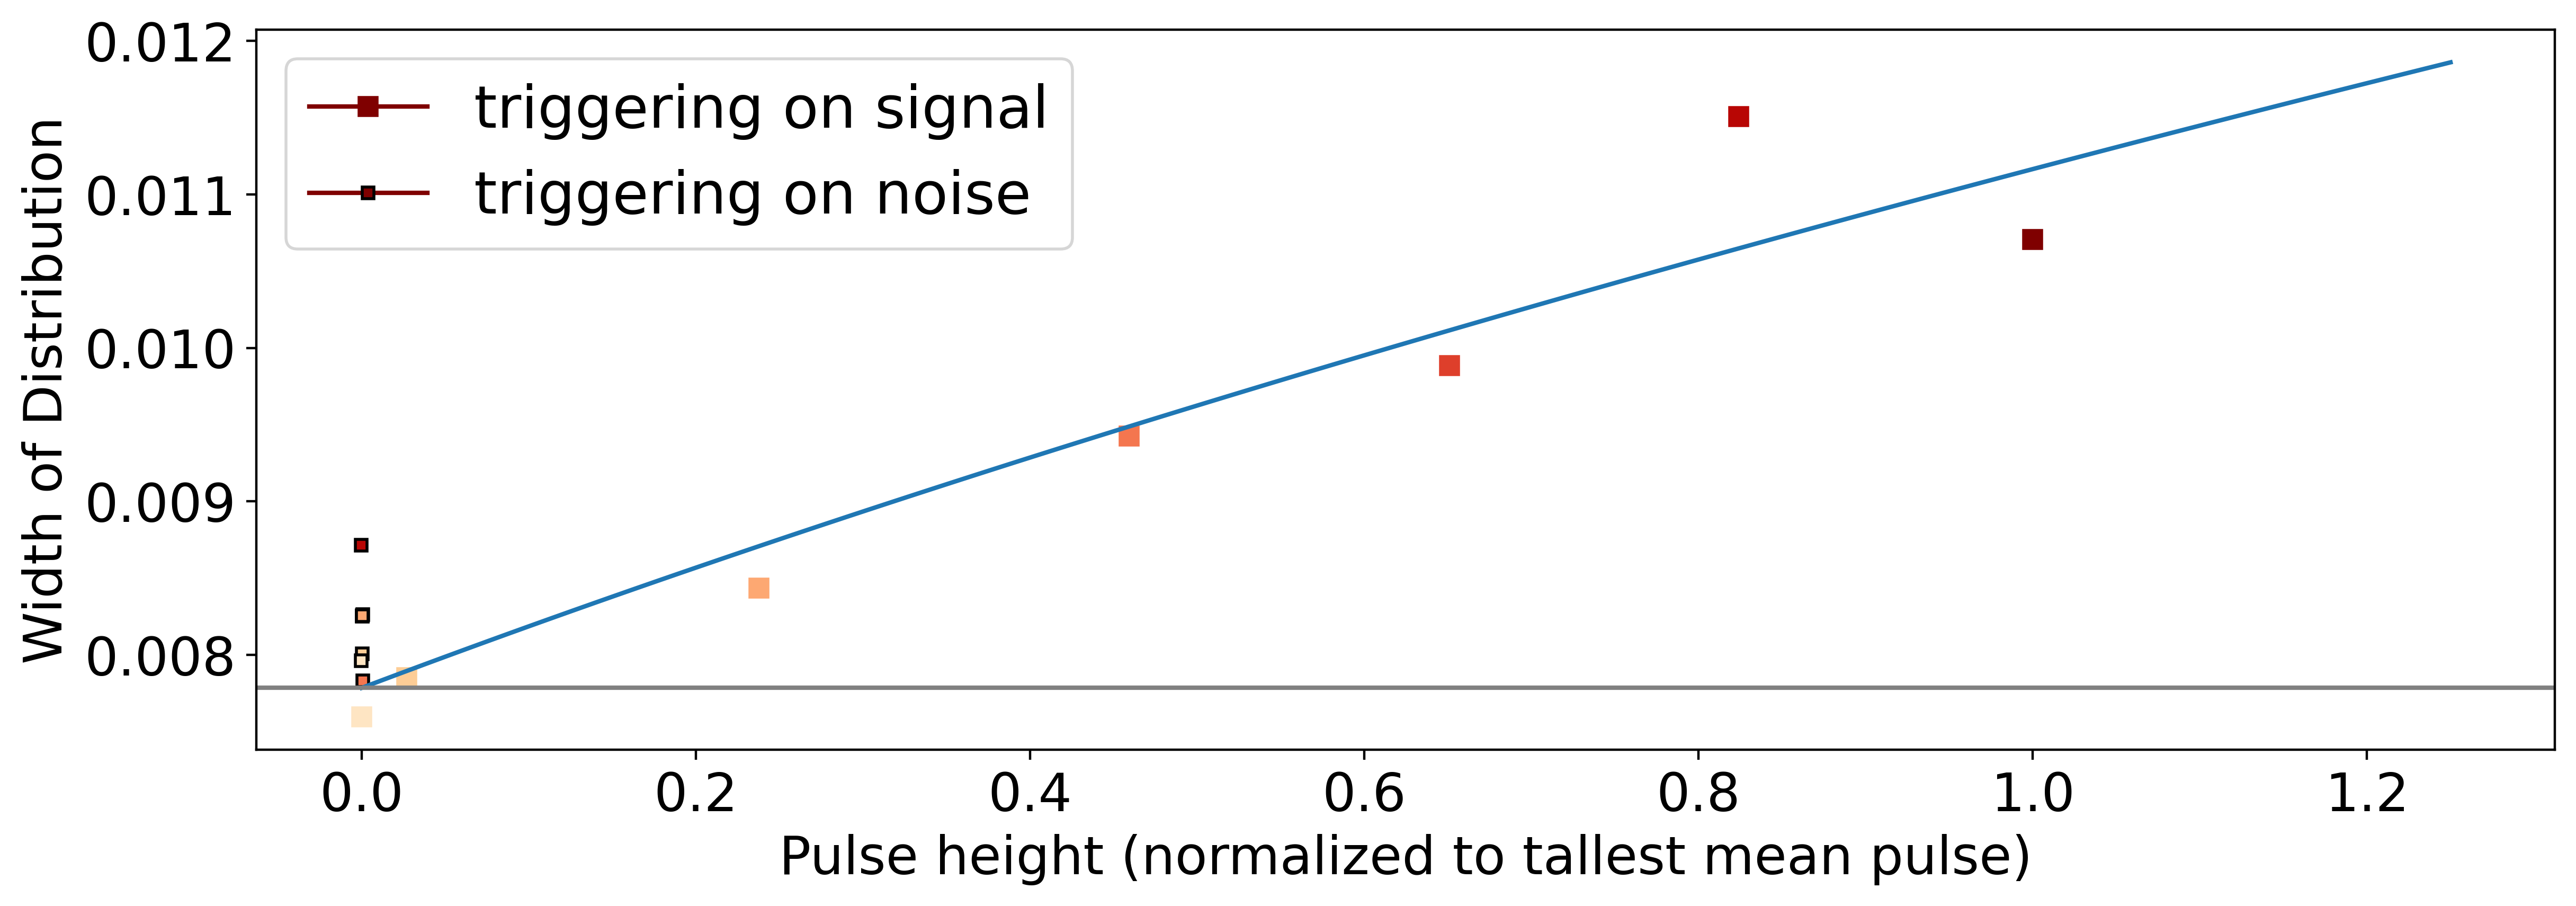

In [17]:
plt.figure(figsize=(14,4.5),dpi=400)
ax2 = plt.gca()

all_mus_raw  = np.zeros(len(keys))
all_sigs_raw = np.zeros(len(keys))

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    data = frac_to_E_keV(data)
    
    mu,sig = fits_df[keys[i]]
    mu_sum,sigma_sum = sums_df[keys[i]]
    mu_max,sigma_max = maxs_df[keys[i]]
    all_mus_raw[i]   = mu
    all_sigs_raw[i]  = sig
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        label1 = 'triggering on signal'
        label2 = 'triggering on noise'
    else:
        label1 = None
        label2 = None
    plt.plot(mu,sig,color=color,ls=None,marker='s',label=label1)
    plt.plot(mu_sum,        sigma_sum,        color=color,ls=None,marker='s',label=label2,markersize=4,markeredgecolor='k')

ax2.set_xlabel('Pulse height (normalized to tallest mean pulse)')
ax2.set_ylabel('Width of Distribution')

def sig(mu,sigma_0,r):
    return np.sqrt(b7_res**2 + (mu)*r)

p0 = [1e-1,1e-2]
f_fit_vals,_ = curve_fit(sig,all_mus_raw,all_sigs_raw,p0)

sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/hv)

print('energy resolution estimate is: ' + str(sigma_0_E_pub))

mu_plot = np.linspace(0,1.25,100)
sigma_s = sig(mu_plot,*f_fit_vals)

# ax2.plot(all_mus_raw,all_sigs_raw,ls=None)
ax2.plot(mu_plot,sigma_s,ls=None)#,label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
ax2.legend(loc='best',fontsize=20)
# ax2.axhline(y=sigma_0_E_pub/1e3,color='grey')
ax2.axhline(y=b7_res,color='grey')

energy resolution estimate is: 320.8781719499591


<ipython-input-20-a09be313c069>:54: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(b7_res**2 + mu*r)
/usr/local/share/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


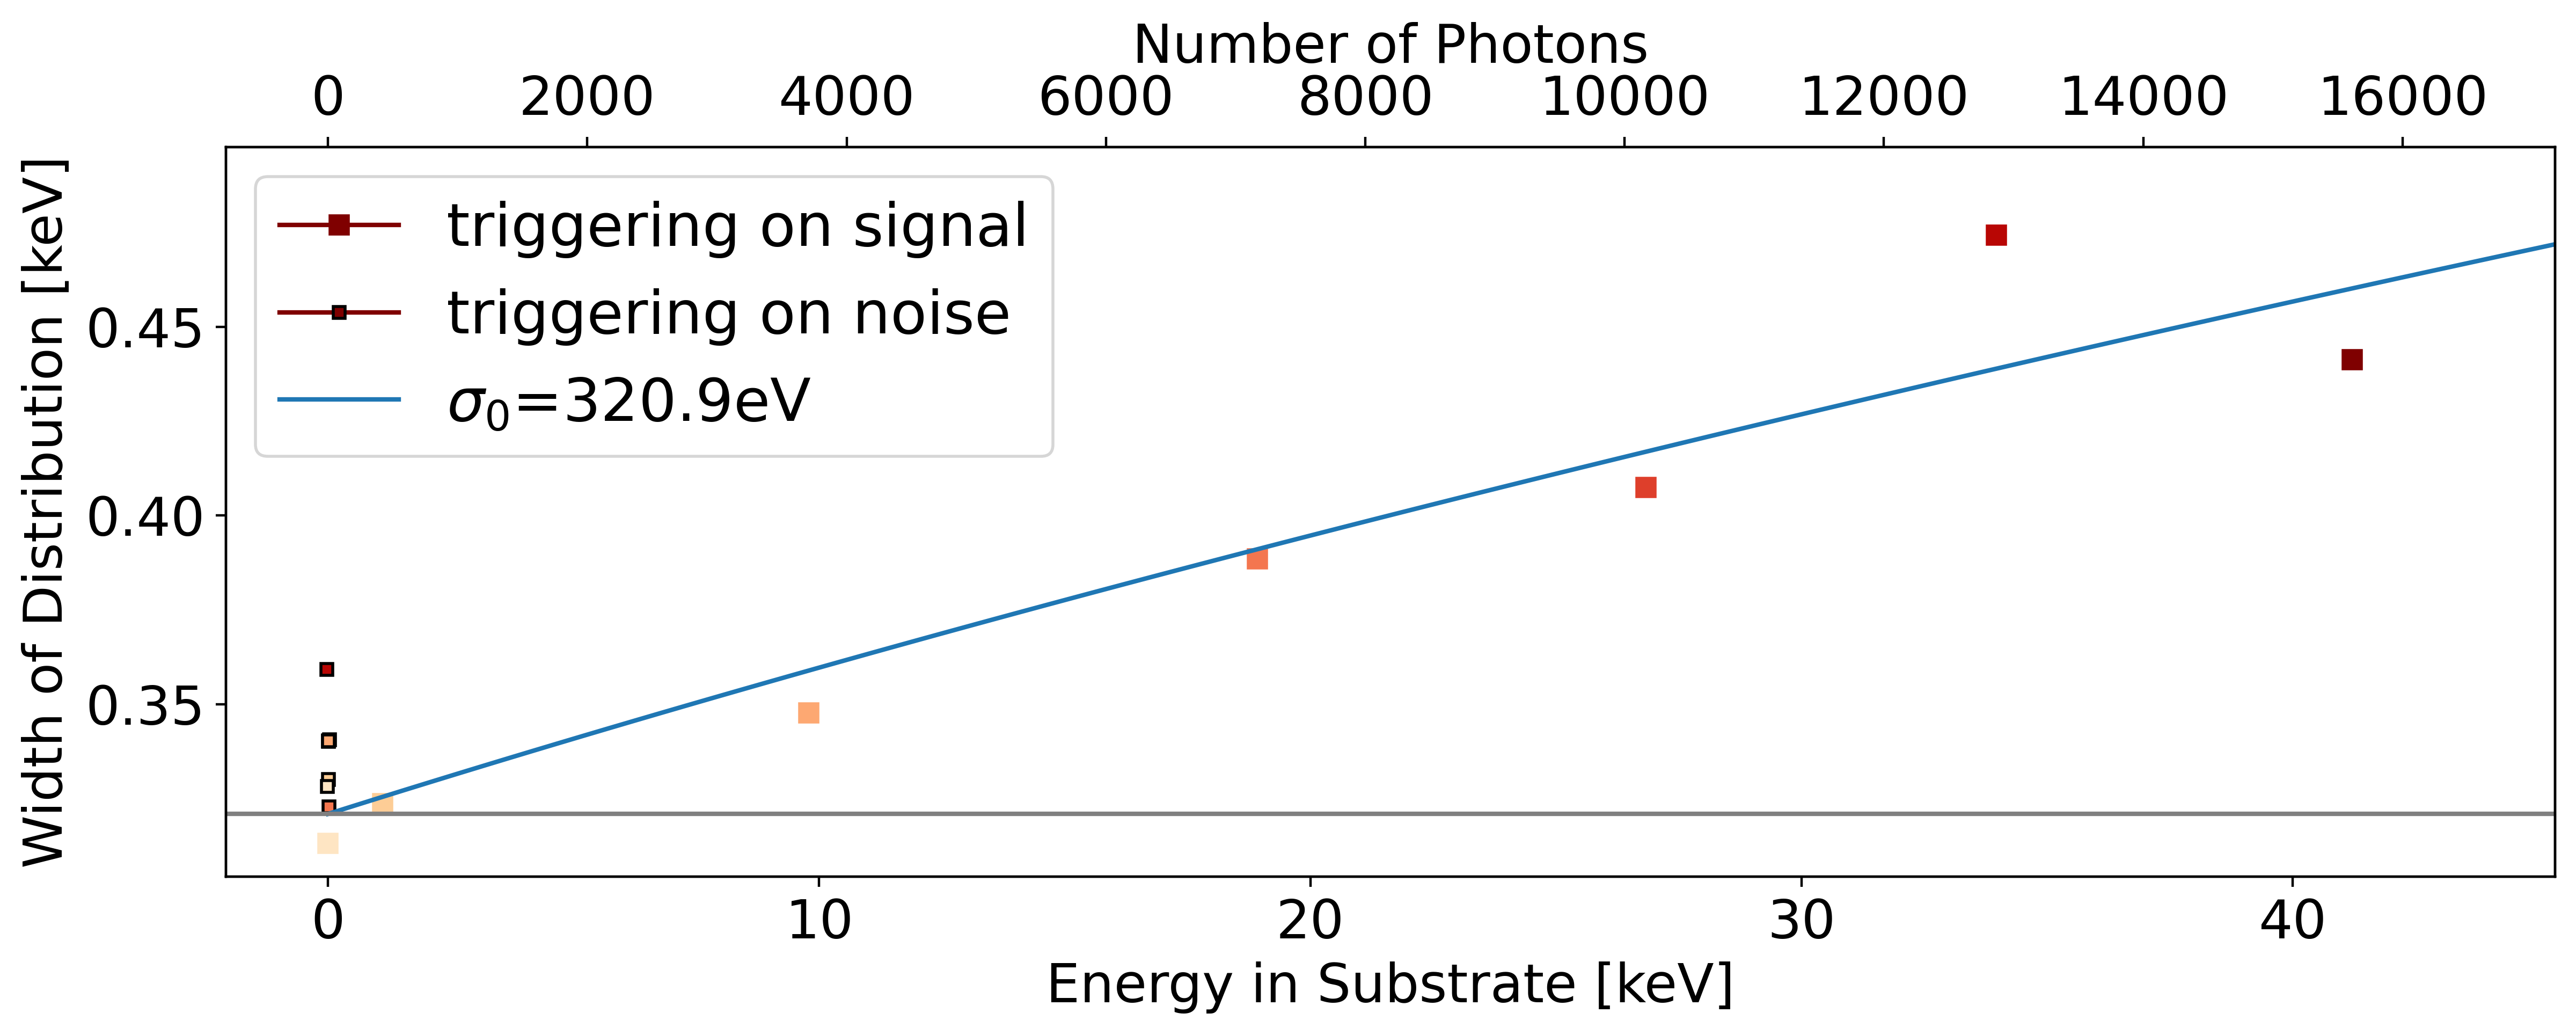

In [20]:
plt.figure(figsize=(14,4.5),dpi=400)
ax2 = plt.gca()

all_mus_raw  = np.zeros(len(keys))
all_sigs_raw = np.zeros(len(keys))

all_mus_df  = np.zeros(len(keys))
all_sigs_df = np.zeros(len(keys))

## Loop over the voltages
for i in np.arange(len(keys)):
    data = data_df[keys[i]]
    data = data[data>-998]
    data = frac_to_E_keV(data)
    
    mu,sig = fits_df[keys[i]]
    mu_sum,sigma_sum = sums_df[keys[i]]
    mu_max,sigma_max = maxs_df[keys[i]]
    all_mus_raw[i]   = mu
    all_sigs_raw[i]  = sig
    all_mus_df[i]    = mu * s_df_NEXUS
    all_sigs_df[i]   = sig * s_df_NEXUS
    
    mu = frac_to_E_keV(mu)
    sig = frac_to_E_keV(sig)
    
    mu_sum = frac_to_E_keV(mu_sum)
    sigma_sum = frac_to_E_keV(sigma_sum)
    
    mu_max = frac_to_E_keV(mu_max)
    sigma_max = frac_to_E_keV(sigma_max)
    
    color = cmap( (voltages[i]-1.5) / (np.max(voltages)-1.5) )
    
    if i == 0:
        label1 = 'triggering on signal'
        label2 = 'triggering on noise'
    else:
        label1 = None
        label2 = None
    plt.plot(mu,sig,color=color,ls=None,marker='s',label=label1)
    plt.plot(mu_sum,        sigma_sum,        color=color,ls=None,marker='s',label=label2,markersize=4,markeredgecolor='k')

ax2.set_xlabel('Energy in Substrate [keV]')
ax2.set_ylabel('Width of Distribution [keV]')
xlims = ax2.get_xlim()
ax2.set_xlim([xlims[0],1.1*frac_to_E_keV(1.0)])

ax3 = ax2.twiny()
ax3.set_xlim(E_keV_to_photon(np.array(ax2.get_xlim())))
ax3.set_xlabel("Number of Photons")

def sig(mu,sigma_0,r):
    return np.sqrt(b7_res**2 + mu*r)

p0 = [1e-1,1e-2]
f_fit_vals,_ = curve_fit(sig,all_mus_raw,all_sigs_raw,p0)

sigma_0_E_pub = abs(b7_res)/(f_fit_vals[1]/hv)

print('energy resolution estimate is: ' + str(sigma_0_E_pub))

mu_plot = np.linspace(0,1.25,100)
sigma_s = frac_to_E_keV(sig(mu_plot,*f_fit_vals))
mu_plot = frac_to_E_keV(mu_plot)

# ax2.plot(all_mus_raw,all_sigs_raw,ls=None)
ax2.plot(mu_plot,sigma_s,label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV',ls=None)
ax2.legend(loc='best',fontsize=20)
# ax2.axhline(y=sigma_0_E_pub/1e3,color='grey')
ax2.axhline(y=b7_res*frac_to_E_keV(np.max(all_mus_raw)),color='grey')